# Understanding ambiguity in the lexicon

Here, we explore and attempt to understand the finding that short words tend to have more homophones, at least in English, German, and Dutch. This has been suggested (Piantadosi et al, 2012) as evidence that language evolution selects for **efficiency** by recycling short, presumably easier-to-produce homophones. The original result contains three findings:
* Short words have more homophones
* More frequent words have more homophones
* More phonotactically-probable words have more homophones

But one might ask: is this data best explained by a psychological pressure to **reuse** short words, or can it be equally-well explained by the observation that, independent of psychological pressures, short words should acquire more homophones because:
1. There is simply a higher density of short words in the lexicon, e.g. the ratio of **actual** words to **potential** words is higher for short words than long words.
2. Given the addition of a new word-form (e.g. by sound change, neologisms, etc.), *short* word-forms are more likely to create homophones than long word-forms because there is a greater chance of overlap. (Or conversely, a lower chance of *non-overlap*.)

This makes two predictions:

First, we should observe the same or greater relationship between **word length** and **number of homophones** in randomly-generated lexicons that *look like* English but haven't been subjected to the same psychological pressures. We should also observe the same or greater relationship between **phonotactic probability** and **number of homophones**. Given that we can't obtain frequency estimates for nonexistent words, we cannot test the relationship between **frequency** and **number of homophones**.

Second, we should find that simulating mechanisms of language change, e.g. **sound change**, is more likely to produce homophones for short words than long words.

Note that this explanation is not incompatible with the account offered by Piantadosi et al (2012). Rather, it attempts to clarify why ambiguity in the lexicon is distributed in such a way. There could still be a psychological pressure for short words––but not necessariliy a pressure to **reuse** short words.

# Part 1: Replicate the original finding

First, we attempt to replicate the original finding, using both CELEX and iPHOD. We use the latter because this will be our point of comparison for pseudo-words.

## CELEX replication

Using data from CELEX, we identify the number of homophones for each wordform, then regress **number of homophones** against **number of syllables**. 


In [1]:
import pandas as pd 
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import src.utils as utils
import math
import numpy as np
import seaborn as sns
from tqdm import tqdm
from os import listdir
from collections import Counter

In [2]:
# ~ 52k words, slightly different from Piantadosi
df = pd.read_csv("data/raw/celex_all.csv", sep="\\")
len(df)

52447

In [3]:
# Preprocess
df_processed = utils.preprocess_for_analysis(df)
len(df_processed)

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


35111

In [4]:
X = len(df_processed[df_processed['num_homophones']>=1])
X_per = round((X / len(df_processed)) * 100, 2)
print("Total number of homophonous wordforms: {x}".format(x=X))
print("Percentage of wordforms in lexicon mapping onto multiple lemmas: {x}%".format(x=X_per))

Total number of homophonous wordforms: 5493
Percentage of wordforms in lexicon mapping onto multiple lemmas: 15.64%


In [5]:
# Analysis
result = sm.poisson(formula="num_homophones ~ SylCnt", data=df_processed).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.469239
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                35111
Model:                        Poisson   Df Residuals:                    35109
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Apr 2019   Pseudo R-squ.:                  0.1345
Time:                        15:26:22   Log-Likelihood:                -16475.
converged:                       True   LL-Null:                       -19035.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5035      0.030     16.514      0.000       0.444       0.563
SylCnt        -0.9464      0.015    -63.308      0.000      -0.976      -0.917
==============================================================================
"""

Above, we successfully replicate the finding reported in Piantadosi et al (2012). For reference, they report that all coefficients on *SylCnt* < -.85. We find a similar value, though slightly larger magnitude (probably because we also omit frequency and phonotactic probability, which might explain overlapping variance).

In [6]:
print("Coef = {}".format(result.params['SylCnt']))

Coef = -0.9463926929646285


In [7]:
df_aggregated = utils.agg_homophones_by_syllable(dataframe=df_processed, syl_column="SylCnt")
df_aggregated

/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,num_sylls,mean_homophones,sem_homophones
0,1,0.770093,0.015670
1,2,0.192855,0.004135
2,3,0.100785,0.003231
3,4,0.061627,0.003478
4,5,0.035471,0.004199
5,6,0.017452,0.005475
6,7,0.009091,0.009091
7,8,0.000000,0.000000
8,10,0.000000,0.000000


<ErrorbarContainer object of 3 artists>

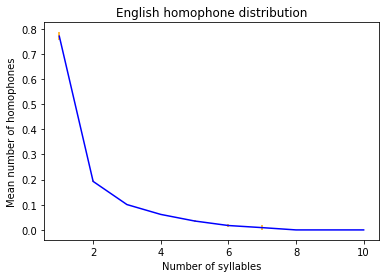

In [8]:
plt.figure()
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")
plt.title("English homophone distribution")
plt.errorbar(df_aggregated['num_sylls'], 
             df_aggregated['mean_homophones'],
             yerr=df_aggregated['sem_homophones'], 
            color="blue", ecolor="orange")

## IPHOD replication

Using data from [IPHOD](http://iphod.com/), we identify the number of homophones for each wordform, then regress **number of homophones** against **number of syllables** and **surprisal**. 

The motivation for using IPHOD here is that IPHOD also has a list of phonotactically-possible English pseudo-words, which we will use to simulate our random lexicons. 

Below, we *save* the values for the coefficients for both both *surprisal* and *number of syllables*. We will then ask whether these coefficients are larger than what you'd expect in a random lexicon.

Surprisingly, we find the reverse effect from the prediction with respect to surprisal: words calculated to have higher surprisal normalized to word length (`-math.log(word-average triphoneme probability)`) have *more* homophones. Piantadosi et al (2012) found a positive effect of surprisal in English, but not significant. 

In [9]:
# Parameters
params = {'syllable_term': 'NSyll',
		  'phoneme_term': 'NPhon'}

FORMULA = 'num_homophones ~ {syl} + {prob}'.format(syl=params['syllable_term'],
												   prob='surprisal_normalized')
PHON_COLUMN = 'StTrn'

# Read in data
df = pd.read_csv("data/raw/IPhODv2.0_REALS/IPhOD2_Words.txt", sep="\t")
print("{Y} words in original IPHOD dataset.".format(Y=len(df)))

# Preprocess
df_processed = utils.preprocess_for_analysis(df, phon_column=PHON_COLUMN)
print("{X} words in final analysis".format(X=len(df_processed)))

54030 words in original IPHOD dataset.
51956 words in final analysis


In [10]:
X = len(df_processed[df_processed['num_homophones']>=1])
X_per = round((X / len(df_processed)) * 100, 2)
print("Total number of homophonous wordforms: {x}".format(x=X))
print("Percentage of wordforms in lexicon mapping onto multiple lemmas: {x}%".format(x=X_per))

Total number of homophonous wordforms: 1703
Percentage of wordforms in lexicon mapping onto multiple lemmas: 3.28%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d2e0470>]],
      dtype=object)

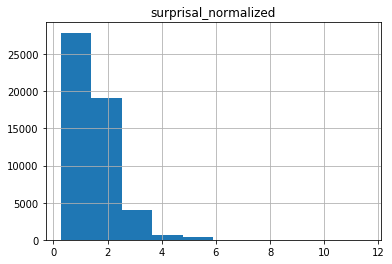

In [11]:
# This is to make sure we don't take log of a negative
df_processed['strTPAV_scaled'] = df_processed['strTPAV'] + .00001
df_processed['surprisal'] = df_processed['strTPAV_scaled'].apply(lambda x: -math.log(x))
df_processed['surprisal_normalized'] = df_processed['surprisal'] / df_processed['NPhon']
df_processed.hist(column='surprisal_normalized')

In [12]:
# Save distribution of surprisal estimates
REAL_SURPRISAL = list(df_processed['surprisal_normalized'])

In [29]:
result = sm.poisson(formula="num_homophones ~ NSyll + surprisal", data=df_processed).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.145086
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                51956
Model:                        Poisson   Df Residuals:                    51953
Method:                           MLE   Df Model:                            2
Date:                Mon, 29 Apr 2019   Pseudo R-squ.:                  0.1676
Time:                        15:27:18   Log-Likelihood:                -7538.1
converged:                       True   LL-Null:                       -9055.4
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8339      0.241     -3.465      0.001      -1.306      -0.362
NSyll         -1.5616      0.038    -40.975      0.000      -1.636      -1.487
surprisal      0.0655      0.022      2.924      0.003       0.022       0.109
==============================================================================
"""

In [30]:
REAL_LENGTH_COEF = result.params['NSyll']
REAL_SURPRISAL_COEF = result.params['surprisal']
REAL_INTERCEPT = result.params['Intercept']
NUM_WORDS = len(df_processed)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1da6e748>]],
      dtype=object)

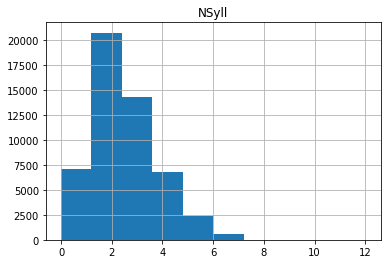

In [31]:
df_processed.hist(column="NSyll")

## Post-hoc: Does phonotactic probability scale with length?

(Answer: Words with more syllables have lower surprisal, even after normalizing for word length.)

In [16]:
reg_prob_length = sm.ols(formula="surprisal ~ NSyll", data=df_processed).fit()
reg_prob_length.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              surprisal   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                 1.182e+04
Date:                Mon, 29 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:26:26   Log-Likelihood:                -71444.
No. Observations:               51956   AIC:                         1.429e+05
Df Residuals:                   51954   BIC:                         1.429e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9826      0.011    927.417      0.000       9.961      10.004
NSyll         -0.4174      0.004   -108.734      0.000      -0.425      -0.410
==============================================================================
Omnibus:                     1390.273   Durbin-Watson:                   1.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              769.907
Skew:                           0.122   Prob(JB):                    6.56e-168
Kurtosis:                       2.456   Cond. No.                         7.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Curiosity: Above and beyond morpheme count?



In [17]:
df_celex = pd.read_csv("data/raw/celex_all.csv", sep="\\")
df_celex_processed = utils.preprocess_for_analysis(df_celex)
df_merged = pd.merge(df_processed, df_celex_processed, on="Word")

In [18]:
len(df_merged)

22872

In [19]:
reg_prob_length = sm.ols(formula="surprisal ~ CompCnt + NSyll", data=df_merged).fit()
reg_prob_length.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              surprisal   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     2953.
Date:                Mon, 29 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:26:29   Log-Likelihood:                -31055.
No. Observations:               22872   AIC:                         6.212e+04
Df Residuals:                   22869   BIC:                         6.214e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0261      0.017    579.445      0.000       9.992      10.060
CompCnt       -0.0399      0.008     -4.754      0.000      -0.056      -0.023
NSyll         -0.4157      0.006    -72.234      0.000      -0.427      -0.404
==============================================================================
Omnibus:                      577.478   Durbin-Watson:                   1.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.417
Skew:                           0.086   Prob(JB):                     1.07e-67
Kurtosis:                       2.458   Cond. No.                         9.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<ErrorbarContainer object of 3 artists>

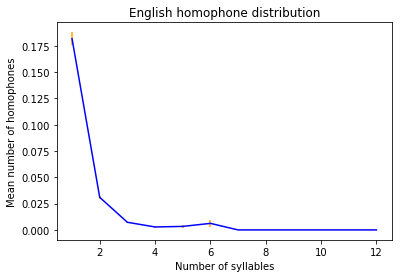

In [21]:
df_aggregated = utils.agg_homophones_by_syllable(df_processed)
df_aggregated = df_aggregated[df_aggregated['num_sylls']>0]
plt.figure()
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")
plt.title("English homophone distribution")
plt.errorbar(df_aggregated['num_sylls'], 
             df_aggregated['mean_homophones'],
             yerr=df_aggregated['sem_homophones'], 
            color="blue", ecolor="orange")

## what about neighborhood density?

A related question is whether homophones come from sparser or denser neighborhoods. Is there a trade-off between signal ambiguity and lexical ambiguity?

It looks like words with higher neighborhood density are likely to have more homophones. 

In [22]:
reg_density = sm.poisson(formula="num_homophones ~ strDENS", data=df_processed).fit()
reg_density.summary()

Optimization terminated successfully.
         Current function value: 0.126116
         Iterations 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                51956
Model:                        Poisson   Df Residuals:                    51954
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Apr 2019   Pseudo R-squ.:                  0.2764
Time:                        15:26:56   Log-Likelihood:                -6552.5
converged:                       True   LL-Null:                       -9055.4
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4215      0.037   -120.268      0.000      -4.494      -4.349
strDENS        0.1108      0.001     81.660      0.000       0.108       0.113
==============================================================================
"""

In [23]:
df_agg_density = utils.agg_homophones_by_syllable(dataframe=df_processed, syl_column="strDENS")
df_agg_density['density'] = df_agg_density['num_sylls']

<ErrorbarContainer object of 3 artists>

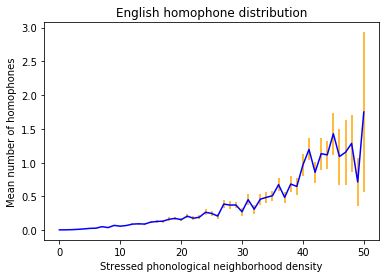

In [24]:
plt.figure()
plt.xlabel("Stressed phonological neighborhood density")
plt.ylabel("Mean number of homophones")
plt.title("English homophone distribution")
plt.errorbar(df_agg_density['density'], 
             df_agg_density['mean_homophones'],
             yerr=df_agg_density['sem_homophones'], 
            color="blue", ecolor="orange")

In [25]:
reg_density_plus_syllables = sm.poisson(formula="num_homophones ~ strDENS + NSyll + surprisal_normalized", data=df_processed).fit()
reg_density_plus_syllables.summary()

Optimization terminated successfully.
         Current function value: 0.124473
         Iterations 17


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                51956
Model:                        Poisson   Df Residuals:                    51952
Method:                           MLE   Df Model:                            3
Date:                Mon, 29 Apr 2019   Pseudo R-squ.:                  0.2858
Time:                        15:26:59   Log-Likelihood:                -6467.1
converged:                       True   LL-Null:                       -9055.4
                                        LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.6569      0.105    -34.663      0.000      -3.864      -3.450
strDENS                  0.0885      0.002     40.155      0.000       0.084       0.093
NSyll                   -0.3896      0.040     -9.710      0.000      -0.468      -0.311
surprisal_normalized     0.1140      0.019      5.986      0.000       0.077       0.151
========================================================================================
"""

In [26]:
syllables_and_density = sm.ols(formula="strDENS ~ NSyll", data=df_processed).fit()
syllables_and_density.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                strDENS   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                 2.144e+04
Date:                Mon, 29 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:26:59   Log-Likelihood:            -1.6705e+05
No. Observations:               51956   AIC:                         3.341e+05
Df Residuals:                   51954   BIC:                         3.341e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.5432      0.068    199.815      0.000      13.410      13.676
NSyll         -3.5396      0.024   -146.437      0.000      -3.587      -3.492
==============================================================================
Omnibus:                    25945.958   Durbin-Watson:                   1.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           175578.525
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                      10.688   Cond. No.                         7.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
def agg_y_by_x(dataframe, x = "NSyll", y = "num_homophones", n_se = 1):
    """Aggregate homophones by number of syllables."""
    means_table = pd.pivot_table(dataframe, values=y,
               columns=x,
               aggfunc=np.mean)
    sem_table = pd.pivot_table(dataframe, values=y,
                   columns=x,
                   aggfunc=ss.sem)
    
    num_sylls = list(range(1, max(sem_table)+1))
    means = [means_table[i][y] for i in num_sylls]
    sems = [n_se*sem_table[i][y] for i in num_sylls]
    
    return pd.DataFrame.from_dict({'num_sylls': num_sylls,
                                   'mean_homophones': means,
                                   'sem_homophones': sems})
                            

<ErrorbarContainer object of 3 artists>

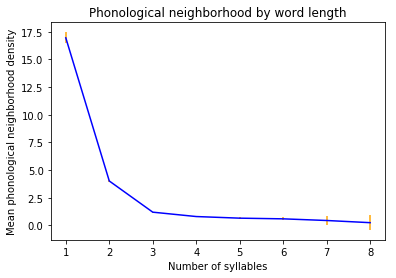

In [28]:
df_density_syllables = agg_y_by_x(df_processed, x="NSyll", y = "strDENS", n_se=4)
plt.figure()
plt.xlabel("Number of syllables")
plt.ylabel("Mean phonological neighborhood density")
plt.title("Phonological neighborhood by word length")
plt.errorbar(df_density_syllables['num_sylls'], 
             df_density_syllables['mean_homophones'],
             yerr=df_density_syllables['sem_homophones'], 
            color="blue", ecolor="orange")

# Part 2: Conduct same analysis on pseudo-words

Now we conduct the same analyses on the set of pseudowords in IPHOD. Specifically, we randomly sample from the 814840 pseudowords 100 times. Each time, we construct a random lexicon of roughly the same size (~50k words), with the same distribution of word lengths and word probabilities.

## Loading and processing data

In [32]:
PATH = "data/raw/IPhODv2.0_PSEUDO"
PHON_COLUMN = 'StTrn'

In [33]:
sources = []
files = listdir(PATH)
print("Loading pseudo-words from files...")
for f in tqdm(files):
	if "IPhOD2_Pseudos" in f:
		temp = pd.read_csv("{path}/{file_name}".format(path=PATH, file_name=f), sep="\t")
		sources.append(temp)

df = pd.concat(sources)

  0%|          | 0/19 [00:00<?, ?it/s]

Loading pseudo-words from files...


100%|██████████| 19/19 [00:12<00:00,  1.57s/it]


In [34]:
print("{X} pseudowords in all.".format(X=len(df)))

814840 pseudowords in all.


In [35]:
df = df.drop_duplicates(subset=PHON_COLUMN)
print("{X} pseudowords after dropping duplicate wordforms.".format(X=len(df)))

761688 pseudowords after dropping duplicate wordforms.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1eaf1f98>]],
      dtype=object)

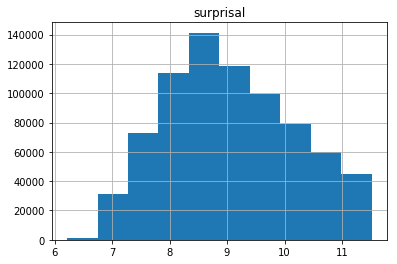

In [36]:
df['strTPAV_scaled'] = df['strTPAV'] + .00001
df['surprisal'] = df['strTPAV_scaled'].apply(lambda x: -math.log(x))
df.hist(column='surprisal')

## Running simulations

### Weighted sampling

In [39]:
ACTUAL_DISTRIBUTION = Counter(df_processed['NSyll'])
ACTUAL_DISTRIBUTION

Counter({1: 7132,
         3: 14329,
         2: 20759,
         4: 6785,
         5: 2400,
         6: 482,
         7: 56,
         12: 1,
         8: 8,
         9: 1,
         0: 3})

In [40]:
df_dist = pd.DataFrame.from_dict({
    'number_syllables': list(ACTUAL_DISTRIBUTION.keys()),
    'count': list(ACTUAL_DISTRIBUTION.values())
})
df_dist.sort_values('number_syllables')

,number_syllables,count
10,0,3
0,1,7132
2,2,20759
1,3,14329
3,4,6785
4,5,2400
5,6,482
6,7,56
8,8,8
9,9,1


In [41]:
ITERATIONS = 100

In [45]:
length_coefs_with_weights, length_coefs_without_weights = [], []
phonotactic_coefs_with_weights, phonotactic_coefs_without_weights = [], []
all_coefs = []
agg_temps = []
surprisals = []

In [46]:
def sample_and_compute(syllable_number_dist, dataframe, weight=True):

    temp = []
    for syl, num in syllable_number_dist.items():
        df_subset = dataframe[dataframe['NSyll']==syl]
        if len(df_subset) > 0: # num
            # Weight sampling by selecting higher-probability words
            if weight:
                temp.append(df_subset.sample(num, replace=True, weights=df_subset['strTPAV']))
            else:
                temp.append(df_subset.sample(num, replace=True))


    df_sampled = pd.concat(temp)
    df_sampled['Word_recoded'] = df_sampled['Word'].apply(lambda x: x.split(" (")[0])
    
    # Preprocess
    df_processed = utils.preprocess_for_analysis(df_sampled, 
                                                 word_column='Word_recoded',
                                                 phon_column=PHON_COLUMN)

    # Analysis
    result = sm.poisson(formula='num_homophones ~ NSyll + surprisal', data=df_processed).fit(disp=0)
    
    return (df_processed, result.params['NSyll'], result.params['surprisal'])

In [47]:
for i in tqdm(list(range(ITERATIONS))):

    df_processed_without, length_without_weight, phon_without_weight = sample_and_compute(syllable_number_dist=ACTUAL_DISTRIBUTION,
                                                                   dataframe=df,
                                                                   weight=False)

    df_processed_with, length_with_weight, phon_with_weight = sample_and_compute(syllable_number_dist=ACTUAL_DISTRIBUTION,
                                                                   dataframe=df,
                                                                   weight=True)

    
    all_coefs.append({
        'nsyll_unweighted': length_without_weight,
        'nsyll_weighted': length_with_weight,
        'surprisal_unweighted': phon_without_weight,
        'surprisal_weighted': phon_with_weight
    })
    
    s, t = list(df_processed_without['surprisal']), list(df_processed_with['surprisal'])
    surprisals.append((s, t))
    
    df_agg = utils.agg_homophones_by_syllable(df_processed_with)
    
    agg_temps.append(df_agg)

100%|██████████| 100/100 [05:52<00:00,  3.19s/it]


In [48]:
for i in range(len(agg_temps)):
    agg_temps[i]['row'] = i
df_agg_all = pd.concat(agg_temps)
df_agg_all.to_csv("data/aggregated_simulations.csv")

### Compare surprisal of pseudowords to real words

If I'm interpreting these tests correctly, it looks like the pseudoword lexicons are more phonotactically plausible than the real lexicon? (E.g., the surprisal tends to be lower in the pseudoword lexicons than the real English lexicon, especially when weighting by phonotactic plausibility.)

In [49]:
tests = []
real_mean = np.mean(REAL_SURPRISAL)
for s_without, s_with in surprisals:

    test_without = ss.ttest_ind(s_without, REAL_SURPRISAL)
    test_with = ss.ttest_ind(s_with, REAL_SURPRISAL)
    
    tests.append({
        'test_without': test_without.statistic,
        'test_with': test_with.statistic,
        'mean_without': np.mean(s_without),
        'mean_with': np.mean(s_with)
    })
df_test = pd.DataFrame.from_dict(tests)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10865da90>]],
      dtype=object)

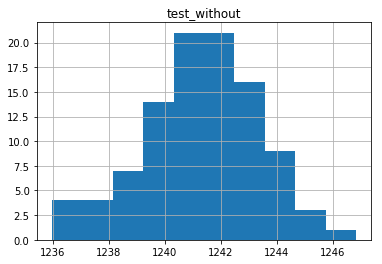

In [50]:
df_test.hist(column='test_without')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a63d9ff98>]],
      dtype=object)

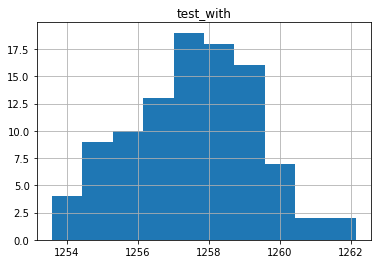

In [51]:
df_test.hist(column='test_with')

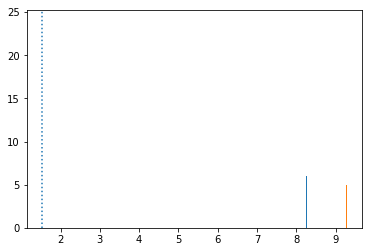

In [52]:
plt.hist(df_test['mean_with'], label="mean surprisal with weighted sampling")
plt.hist(df_test['mean_without'], label="mean surprisal without weighted sampling")
plt.axvline(x=real_mean, linestyle="dotted")


### Comparing weighted vs. unweighted together

In [53]:
df_coefs = pd.DataFrame(all_coefs)

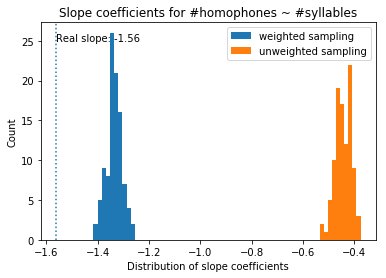

In [59]:
plt.hist(df_coefs['nsyll_weighted'], label="weighted sampling")
plt.hist(df_coefs['nsyll_unweighted'], label="unweighted sampling")
plt.axvline(x=REAL_LENGTH_COEF, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(REAL_LENGTH_COEF, 2)),
                                     x=REAL_LENGTH_COEF, y =25)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
plt.legend(loc='upper right')
plt.show()

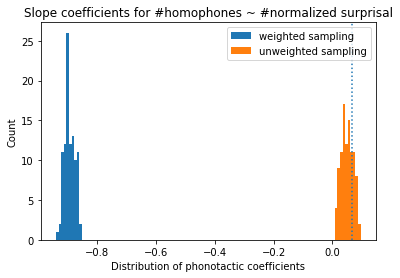

In [60]:
plt.hist(df_coefs['surprisal_weighted'], label="weighted sampling")
plt.hist(df_coefs['surprisal_unweighted'], label="unweighted sampling")
plt.axvline(x=REAL_SURPRISAL_COEF, linestyle="dotted")
# plt.axvline(x=mean_random_slope, linestyle="dotted", color="blue")
# plt.text(s="Real slope: {sl}".format(sl=REAL_LENGTH_COEF),x=REAL_LENGTH_COEF, y=5)
# plt.xlim(-.05, .05)
plt.xlabel("Distribution of phonotactic coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #normalized surprisal")
plt.legend(loc='upper right')
plt.show()